In [1043]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import datetime
import math
from sklearn.preprocessing import LabelEncoder
import statistics
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from itertools import product
from math import sqrt
import json
from sklearn.preprocessing import PolynomialFeatures

#Models
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Dropout,Reshape
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

In [1044]:
sample=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [1045]:
#Lets first split our train dataset into the training portions and validation portions
X = train.drop(columns=['Transported'])
y = train['Transported']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [1046]:
# Shows number of rows in X_train
X_train.shape[0]

6085

In [1047]:
#Next,lets have a look at our data

def data_sum(dataframe):
    nulls=[]
    count=[]
    unique=[]
    null_percentage=[]
    dtype=[]

    for col in dataframe.columns:
        nulls.append(dataframe[col].isnull().sum())
        count.append(dataframe[col].count())
        unique.append(dataframe[col].nunique())
        total_rows=dataframe.shape[0]
        null_percentage.append(dataframe[col].isnull().sum()*100/total_rows)
        dtype.append(dataframe[col].dtype)
    
    summary=pd.DataFrame({
        'Column': dataframe.columns,
        'Nulls': nulls,
        'Non-Null Count': count,
        'Unique Values': unique,
        'Null Percentage': null_percentage,
        'Data Type': dtype
    })

    return(summary)

X_train_summary=data_sum(X_train)
print(X_train_summary)

          Column  Nulls  Non-Null Count  Unique Values  Null Percentage  \
0    PassengerId      0            6085           6085         0.000000   
1     HomePlanet    140            5945              3         2.300740   
2      CryoSleep    154            5931              2         2.530813   
3          Cabin    142            5943           4860         2.333607   
4    Destination    122            5963              3         2.004930   
5            Age    129            5956             80         2.119967   
6            VIP    153            5932              2         2.514380   
7    RoomService    114            5971           1026         1.873459   
8      FoodCourt    122            5963           1216         2.004930   
9   ShoppingMall    146            5939            891         2.399343   
10           Spa    122            5963           1077         2.004930   
11        VRDeck    129            5956           1050         2.119967   
12          Name    138  

In [1048]:
#Lets first drop some colums we wont be using
X_train=X_train.drop(columns=['PassengerId','Name'])

In [1049]:
X_train['TotalSpending'] = X_train[['FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].sum()

In [1050]:
X_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending
3032,Europa,False,B/120/S,TRAPPIST-1e,43.0,False,0.0,1440.0,0.0,85.0,150.0,NaN
7757,Europa,True,C/273/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,NaN
1795,Earth,False,G/300/S,TRAPPIST-1e,46.0,False,8.0,652.0,0.0,5.0,90.0,NaN
1702,Earth,False,F/346/S,TRAPPIST-1e,33.0,False,0.0,763.0,8.0,2.0,30.0,NaN
6634,Earth,False,F/1334/S,55 Cancri e,24.0,False,0.0,58.0,618.0,0.0,41.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,Earth,NaN,G/988/S,TRAPPIST-1e,18.0,False,14.0,2.0,144.0,610.0,0.0,NaN
5191,Mars,False,F/1063/S,TRAPPIST-1e,50.0,NaN,690.0,0.0,30.0,762.0,428.0,NaN
5390,Earth,False,F/1194/P,PSO J318.5-22,22.0,False,158.0,0.0,476.0,0.0,26.0,NaN
860,Mars,False,F/191/P,TRAPPIST-1e,34.0,False,379.0,0.0,1626.0,0.0,0.0,NaN


In [1051]:
X_train.corr()

/tmp/ipykernel_32/131534602.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train.corr()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending
Age,1.000000,0.063455,0.131770,0.035980,0.127165,0.100089,NaN
RoomService,0.063455,1.000000,-0.016009,0.042314,0.003144,-0.018663,NaN
FoodCourt,0.131770,-0.016009,1.000000,-0.008833,0.209270,0.242087,NaN
ShoppingMall,0.035980,0.042314,-0.008833,1.000000,0.022235,0.002684,NaN
Spa,0.127165,0.003144,0.209270,0.022235,1.000000,0.173287,NaN
VRDeck,0.100089,-0.018663,0.242087,0.002684,0.173287,1.000000,NaN
TotalSpending,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First lets split into deck num side 

In [1052]:
X_train[["Deck","Num","Side"]]=X_train["Cabin"].str.split("/",expand = True)

In [1053]:
X_train.drop(columns = ['Cabin'], inplace = True)

In [1054]:
#Now im trying to impute using interpolation
# Age & Amenities has a relationship. The older, the more spending.
X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']] = X_train[['Age', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'RoomService']].interpolate(method='linear')

In [1055]:
#lets see how the dataframe is like now
X_train_2_summary=data_sum(X_train)
X_train_2_summary

,Column,Nulls,Non-Null Count,Unique Values,Null Percentage,Data Type
0,HomePlanet,140,5945,3,2.300740,object
1,CryoSleep,154,5931,2,2.530813,object
2,Destination,122,5963,3,2.004930,object
3,Age,0,6085,114,0.000000,float64
4,VIP,153,5932,2,2.514380,object
5,RoomService,0,6085,1060,0.000000,float64
6,FoodCourt,0,6085,1266,0.000000,float64
7,ShoppingMall,0,6085,938,0.000000,float64
8,Spa,0,6085,1114,0.000000,float64
9,VRDeck,0,6085,1101,0.000000,float64


Looks like we have completed the imputing for numerical features now lets work on the categorical features.

Aus: Inspecting and finetuning Arden's imputation. 
Removed his X_valid and test imputation.

<!--  --> from sklearn.impute import SimpleImputer. Constant strategy is better for one-hot encoding


In [1056]:
categorical = X_train.dtypes == 'object'
categorical

HomePlanet        True
CryoSleep         True
Destination       True
Age              False
VIP               True
RoomService      False
FoodCourt        False
ShoppingMall     False
Spa              False
VRDeck           False
TotalSpending    False
Deck              True
Num               True
Side              True
dtype: bool

Look at the columns with categorical data.
Starting from HomePlanet.

In [1057]:
homeplanet_isna = X_train[['HomePlanet']].isna()

homeplanet_isna.value_counts()

HomePlanet
False         5945
True           140
dtype: int64

Aus help to put some imputation for Arden

In [1058]:
# Assume Arden say PSO means majority from Earth
X_train.loc[X_train["Destination"]=="PSO J318.5-22","HomePlanet"] = X_train.loc[X_train["Destination"]=="PSO J318.5-22","HomePlanet"].fillna("Earth")

# Aus use the 'Majority' method 
X_train.loc[X_train["Destination"]=="55 Cancri e","HomePlanet"]=X_train.loc[X_train["Destination"]=="55 Cancri e","HomePlanet"].fillna("Europa")
X_train.loc[X_train["Destination"]=="TRAPPIST-1e","HomePlanet"]=X_train.loc[X_train["Destination"]=="TRAPPIST-1e","HomePlanet"].fillna("Earth")
X_train.loc[X_train['VIP'] == 'FALSE','Destination'] = X_train.loc[X_train['VIP'] == 'FALSE','Destination'].fillna('TRAPPIST-1e')

X_train.loc[X_train['TotalSpending'] > 5000, 'VIP'] = X_train.loc[X_train['TotalSpending'] > 5000, 'VIP'].fillna(True)

X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'ffill')
X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Earth', 'Destination'].fillna(method = 'bfill')
X_train.loc[X_train['HomePlanet'] == 'Europa', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Europa', 'Destination'].fillna('55 Cancri e')
X_train.loc[X_train['HomePlanet'] == 'Mars', 'Destination'] = X_train.loc[X_train['HomePlanet'] == 'Mars', 'Destination'].fillna('TRAPPIST-1e')
X_train["TotalSpending"]=X_train[["RoomService","Spa","FoodCourt","VRDeck",'ShoppingMall']].sum(axis=1)
X_train.loc[X_train["TotalSpending"]>=5000,"CryoSleep"]=X_train.loc[X_train["TotalSpending"]>=5000,"CryoSleep"].fillna(False)
X_train.loc[X_train["TotalSpending"]==0,"CryoSleep"]=X_train.loc[X_train["TotalSpending"]==0,"CryoSleep"].fillna(True)

X_train["CryoSleep"]=X_train["CryoSleep"].fillna(False)

X_train.loc[X_train['Deck']=='A','HomePlanet']=X_train.loc[X_train['Deck']=='A','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='B','HomePlanet']=X_train.loc[X_train['Deck']=='B','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='C','HomePlanet']=X_train.loc[X_train['Deck']=='C','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='T','HomePlanet']=X_train.loc[X_train['Deck']=='T','HomePlanet'].fillna("Europa")
X_train.loc[X_train['Deck']=='G','HomePlanet']=X_train.loc[X_train['Deck']=='G','HomePlanet'].fillna("Earth")

In [1059]:
# pd.get_dummies(X_train['CryoSleep'][1])

In [1060]:
X_train_3_summary=data_sum(X_train)
X_train_3_summary

,Column,Nulls,Non-Null Count,Unique Values,Null Percentage,Data Type
0,HomePlanet,1,6084,3,0.016434,object
1,CryoSleep,0,6085,2,0.000000,bool
2,Destination,3,6082,3,0.049302,object
3,Age,0,6085,114,0.000000,float64
4,VIP,153,5932,2,2.514380,object
5,RoomService,0,6085,1060,0.000000,float64
6,FoodCourt,0,6085,1266,0.000000,float64
7,ShoppingMall,0,6085,938,0.000000,float64
8,Spa,0,6085,1114,0.000000,float64
9,VRDeck,0,6085,1101,0.000000,float64


In [1061]:
vip_0 = X_train['VIP'] == 'NaN'
spending = X_train['TotalSpending'] >5000
X_train.loc[vip_0 & spending]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending,Deck,Num,Side


Everything above is what I feel is necessary, the bottom code im not sure which u wanna keep so largely advised to keep working from here

**Arden's Edit:*

Step 1.1: Define X & Y

Step 1.2: Split Cabin into 3 separate columns

Step 1.3: Splitting dataset into train and validation

Step 2.1: Seeing which columns in X_train are in need of imputation/deletion

Find out how to impute a catagorical column based on other columns

i think ill remove the name column as it is unnecessary

<Axes: >

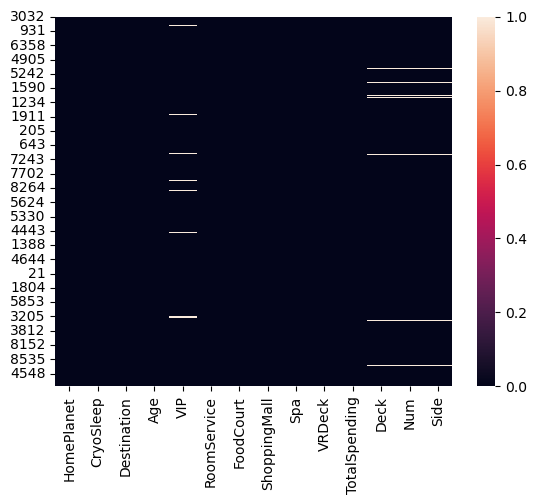

In [1062]:
sns.heatmap(X_train.isna())

In [1063]:
Home_Dest=X_train.groupby("HomePlanet")['Destination'].value_counts()
Home_Dest


HomePlanet  Destination  
Earth       TRAPPIST-1e      2331
            PSO J318.5-22     522
            55 Cancri e       499
Europa      TRAPPIST-1e       835
            55 Cancri e       666
            PSO J318.5-22      17
Mars        TRAPPIST-1e      1039
            55 Cancri e       135
            PSO J318.5-22      38
Name: Destination, dtype: int64

In [1064]:
b=X_train.groupby("HomePlanet")['Deck'].value_counts()
b

HomePlanet  Deck
Earth       G       1777
            F       1203
            E        288
            C          6
            D          5
            B          3
            A          1
            T          1
Europa      B        546
            C        521
            A        170
            D        128
            E         98
            T          4
            F          3
            G          1
Mars        F        774
            E        217
            D        196
Name: Deck, dtype: int64

<Axes: xlabel='HomePlanet', ylabel='TotalSpending'>

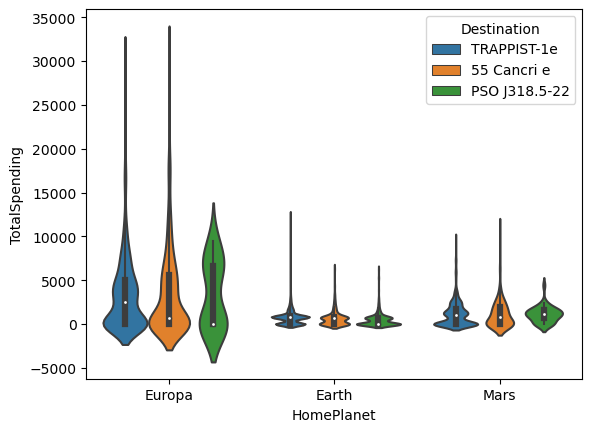

In [1065]:
sns.violinplot(x='HomePlanet',y='TotalSpending',data=X_train,hue="Destination")

In [1066]:
X_train.groupby("Destination")['CryoSleep'].value_counts()

Destination    CryoSleep
55 Cancri e    False         768
               True          532
PSO J318.5-22  False         295
               True          282
TRAPPIST-1e    False        2877
               True         1328
Name: CryoSleep, dtype: int64

In [1067]:
X_train.loc[X_train['HomePlanet']=="Mars",'Destination']=X_train.loc[X_train['HomePlanet']=="Mars",'Destination'].fillna("TRAPPIST-1e")